# Implementing a Neural Network for CIFAR dataset - Convolutional Networks

Remember ex2? Now, you will try to improve it by using CNNs. Using conovolutioal layers when working with images should improve your results.

All the code is written for you (loading images, training loop...), you shoiuld come up with a CNN from your own.

As usual, you can try to add also augmentations, or other advanced tools you learnt (weight decay, learning rate, regularizations...)


## Loading CIFAR dataset

In [1]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy

# applying RandomHorizontalFlip and not vertical
transforms_aug = transforms.RandomChoice([transforms.RandomHorizontalFlip(p=1),
                                          transforms.ColorJitter(brightness=.5, hue=.3),
                                          transforms.RandomEqualize(p=1),
                                          transforms.RandomInvert(p=1)])

transform_train = transforms.Compose(
    [transforms_aug,
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


In [2]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize some of the training images

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img, title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5), dpi=100)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

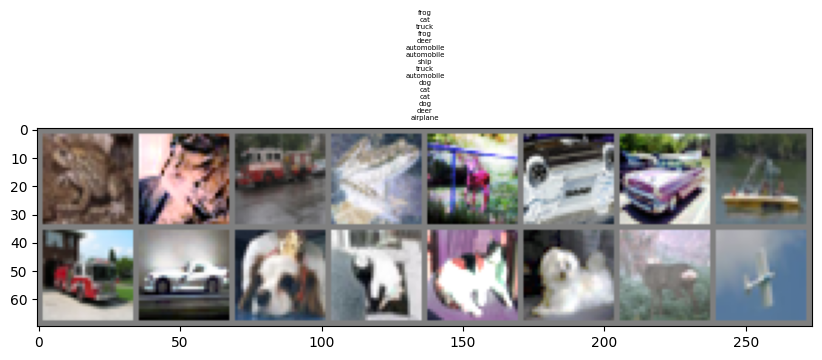

In [5]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## CNN (100 points)

You should define a CNN

In [6]:
#Here is your main code

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv3 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.act4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.act5 = nn.ReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.act6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        # concate 2 directions
        self.flat = nn.Flatten()
        self.dropout_fc1 = nn.Dropout(0.5) 
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout_fc2 = nn.Dropout(0.3) 
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)


    def forward(self, x):
      # first_direction
        x = self.act1(self.conv1(x))
        x = self.act2(self.batch_norm1(self.conv2(x)))
        x = self.pool1(x)

        x = self.act3(self.conv3(x))
        x = self.act4(self.batch_norm2(self.conv4(x)))
        x = self.pool2(x)

        x = self.act5(self.conv5(x))
        x = self.act6(self.batch_norm3(self.conv6(x)))
        x = self.pool3(x)

        x = self.flat(x)
        x = self.dropout_fc1(x)
        x = self.fc1(x)
        x = self.dropout_fc2(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act4): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momen

In [8]:
#!pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
              ReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]         147,584
       BatchNorm2d-4          [-1, 128, 32, 32]             256
              ReLU-5          [-1, 128, 32, 32]               0
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]         147,584
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]         147,584
             ReLU-14            [-1, 12

In [9]:
# If a GPU is available, make the model use it
model = model.to(device)

lr=0.0001
step_size = len(dataloaders['train'].dataset.data) // (batch_size * 2)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=lr, max_lr=lr*5, cycle_momentum=False, step_size_up=step_size, step_size_down=step_size, mode='exp_range', gamma=0.8)

num_epochs = 50

In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

In [11]:
model,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/49
----------
train Loss: 1.6610 Acc: 0.3988
val Loss: 1.1994 Acc: 0.5683

Epoch 1/49
----------
train Loss: 1.1914 Acc: 0.5796
val Loss: 0.9397 Acc: 0.6691

Epoch 2/49
----------
train Loss: 1.0324 Acc: 0.6369
val Loss: 0.8556 Acc: 0.6967

Epoch 3/49
----------
train Loss: 0.9339 Acc: 0.6720
val Loss: 0.8298 Acc: 0.7046

Epoch 4/49
----------
train Loss: 0.8656 Acc: 0.6962
val Loss: 0.7767 Acc: 0.7299

Epoch 5/49
----------
train Loss: 0.8046 Acc: 0.7197
val Loss: 0.7393 Acc: 0.7383

Epoch 6/49
----------
train Loss: 0.7641 Acc: 0.7327
val Loss: 0.6286 Acc: 0.7830

Epoch 7/49
----------
train Loss: 0.7210 Acc: 0.7486
val Loss: 0.6715 Acc: 0.7665

Epoch 8/49
----------
train Loss: 0.6813 Acc: 0.7637
val Loss: 0.6245 Acc: 0.7873

Epoch 9/49
----------
train Loss: 0.6514 Acc: 0.7723
val Loss: 0.6189 Acc: 0.7859

Epoch 10/49
----------
train Loss: 0.6221 Acc: 0.7836
val Loss: 0.5536 Acc: 0.8081

Epoch 11/49
----------
train Loss: 0.5986 Acc: 0.7911
val Loss: 0.5562 Acc: 0.8060

Ep

In [12]:
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1]); plt.plot(dict_res['val'][1]); plt.title('Accuracy'); plt.legend(['train','val'])


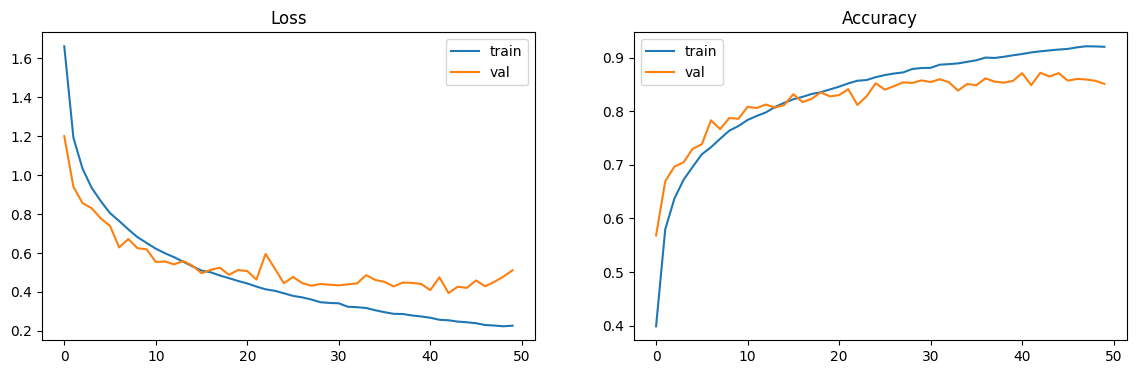

In [13]:
plot_convergence(dict_res,num_epochs ); plt.show()

In [14]:
def predict(model, dataloader):
  model.eval()

  validation_probabilities = []
  validation_predictions = []

  for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      outputs_prob = torch.nn.functional.softmax(outputs)
      probs, index = torch.max(outputs_prob, 1)
      validation_probabilities += probs.tolist()
      _, preds = torch.max(outputs, 1)
      validation_predictions += preds.tolist()
  
  return validation_predictions, validation_probabilities

def class_to_name(class_index):
  return class_names[class_index]
  
validation_predictions, validation_probabilities = predict(model, dataloaders['val'])

<ipython-input-14-6f6d049e4442>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_prob = torch.nn.functional.softmax(outputs)


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
validation_predictions = list(map(class_to_name, validation_predictions))
validation_labels = list(map(class_to_name, dataloaders['val'].dataset.targets))

print(classification_report(validation_labels, validation_predictions, labels=class_names))

              precision    recall  f1-score   support

    airplane       0.84      0.91      0.87      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.86      0.80      0.83      1000
         cat       0.77      0.75      0.76      1000
        deer       0.84      0.89      0.86      1000
         dog       0.80      0.80      0.80      1000
        frog       0.90      0.92      0.91      1000
       horse       0.93      0.88      0.91      1000
        ship       0.94      0.90      0.92      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



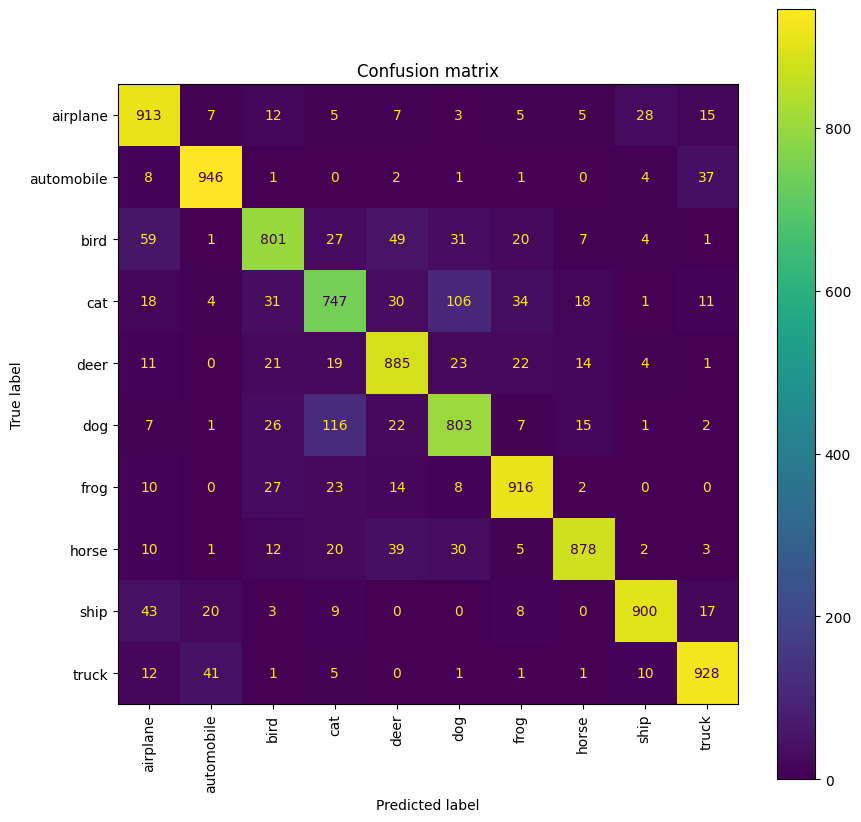

In [16]:
cm = confusion_matrix(validation_labels, validation_predictions)
fig, ax = plt.subplots(figsize=(10,10))

ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax)

plt.xticks(rotation=90);
plt.title("Confusion matrix");

We can see that the model has 87% accuracy.

The model has difficulty distinguishing between a dog and a cat.

After 30 epochs the validation results remain stable compared to the training results that continue to improve, which indicates a state of overfitting.

The augmentation makes the train results to be lower for the first 15 epochs compare to the validation results. I use dropout, l2 regularization and augmentation to avoid over fitting.